## Standard Deviation and Bessel Correction ##

How does sample size affect our measure of standard deviation? When we are looking for an 'unbiased estimator' of a population standard deviation from a sample standard deviaiton, we need to multiply by a factor of n/n-1. Why?

The formula for population variance is shown below:
$$ 
\sigma^{2} = \frac{1}{n} \sum\limits _{i=1}^{n} (x_{i} - \mu)^{2}
$$
where $\mu$ is the population mean.

In practice, however, we almost never have the privelege of collecting data on the entire population. Thus, we calculate the standard deviation of the sample, using the sample mean, $\bar{x}$, to estimate the population mean:
$$ s^{2} = \frac{1}{n} \sum\limits _{i=1}^{n} (x_{i} - \bar{x})^{2} $$

However, this estimator is biased, as we are unable to sample the entire population. The most common correction is Bessel's correction, which slightly increases the variance to account for a sample size smaller than the population.
$$ s^{2} = \frac{1}{n-1} \sum\limits _{i=1}^{n} (x_{i} - \bar{x})^{2} $$

Notice that at large sample sizes (n), the difference between n and n-1 would be negligible. In other words, as the sample size approaches the population size, the sample standard deviation approaches that of the population. We can think of this as a correction factor for any sample size, that becomes more significant with smaller samples.
$$
\frac{1}{n-1} = \frac{1}{n} * \frac{n}{n-1}
$$

This last term is the Bessel correction factor. For the time being, we will take Bessel at his word, and assume that the variance needs to be corrected. We can utilize the first, third, and fourth equations to obtain the following:
$$
\sigma^{2} = \frac{n}{n-1}*s^{2}
$$

Finally, a sqaure root yields a more directly useful relationship for our purposes (AP Stats).
$$\sigma = s*\sqrt{\frac{n}{n-1}}$$

This equation is often presented as how to calculate an unbiased estimator for the population standard deviation. Next, we are going to examine this equation and see if it actually performs as we would expect.

## Sampling from a Normal Distribution ##

In this quick survey, we are going to take samples from a known normal distribution. We can then compare the sample standard deviation, with and without the Bessel correction, to the (known) population standard deviation.

In [117]:
# Necessary imports

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

CPU times: user 172 ms, sys: 76.4 ms, total: 248 ms
Wall time: 111 ms


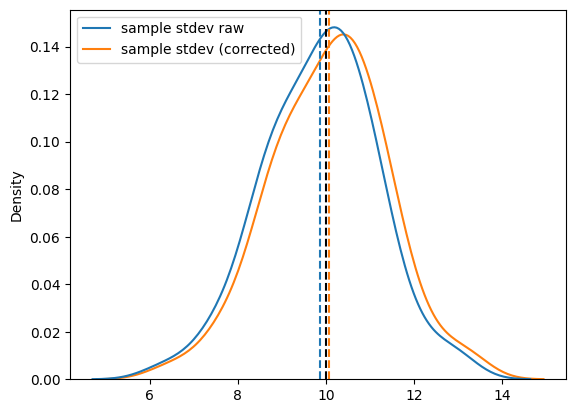

In [118]:
%%time

# Population parameters and sample size

pop_mean = 100
pop_std = 10
sample_size = 25

# Loop to create raw data
data_arr = []

for _ in range(100):
    row_data = np.random.normal(pop_mean, pop_std, sample_size)
    data_arr.append([sample_size, np.mean(row_data), np.std(row_data), np.std(row_data) * math.sqrt(sample_size/(sample_size-1))])
    
df = pd.DataFrame(data = data_arr, columns= ['n', 'sample mean', 'sample stdev raw', 'sample stdev (corrected)'])

sns.kdeplot(data=df[['sample stdev raw', 'sample stdev (corrected)']])
plt.axvline(x=pop_std, color='black', ls='--')
plt.axvline(x = np.mean(df['sample stdev raw']), color='#1f77b4', ls='--'),
plt.axvline(x = np.mean(df['sample stdev (corrected)']), color='#ff7f0e', ls='--');


In [119]:
# Create a column that shows whether or not an error was made
df['error'] = abs(df['sample stdev raw'] - 10) < abs(df['sample stdev (corrected)'] - 10)

# Count the number of errors
df['error'].value_counts()

error
True     51
False    49
Name: count, dtype: int64

**If you rerun this experiment, a new seed may give different results! See the larger experiment below for more consistency**

From this KDE plot (basically a smoothed histogram), we can see the distribution and the mean value of the measured sample standard deviations, both corrected and not. Note that the corrected value, in orange, is closest to the true value of 10, shown in black. (If you got different results, that's great! Rerun the experiment and look for patterns--this is an excellent point of discussion.)

We could rerun this experiment as many times as we would like, but we will end up with similar results in the long term. To illustrate this, we can scale up the experiment.

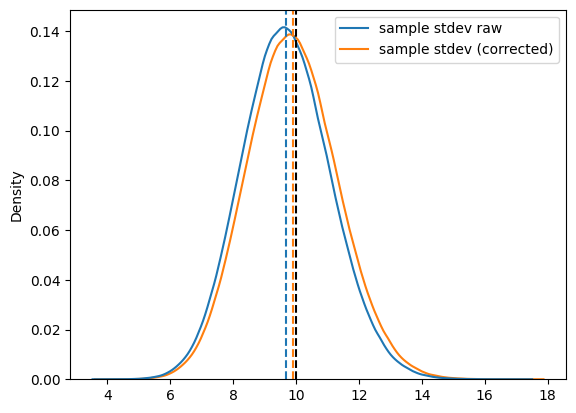

Observed necessary correction factor: 1.0313469274767355
CPU times: user 1min 14s, sys: 1.93 s, total: 1min 16s
Wall time: 1min 15s


In [121]:
%%time

# This the same experiment, at a much larger scale. Time scale is O(n), in case you want to get aggressive with the sample size

large_data_arr = []

for _ in range(1_000_000):
    row_data = np.random.normal(pop_mean, pop_std, sample_size)
    large_data_arr.append([sample_size, np.mean(row_data), np.std(row_data), np.std(row_data) * math.sqrt(sample_size/(sample_size-1))])
    
df1 = pd.DataFrame(data = large_data_arr, columns= ['n', 'sample mean', 'sample stdev raw', 'sample stdev (corrected)'])

sns.kdeplot(data=df1[['sample stdev raw', 'sample stdev (corrected)']])
plt.axvline(x=pop_std, color='black', ls='--')
plt.axvline(x = np.mean(df1['sample stdev raw']), color='#1f77b4', ls='--'),
plt.axvline(x = np.mean(df1['sample stdev (corrected)']), color='#ff7f0e', ls='--')

plt.show()

print(f"Observed necessary correction factor: {10 / np.mean(df1[['sample stdev raw']])}")

Now, let's examine the individual samples of 25 out of the 1,000,000 that we took. In how many of them was the corrected standard deviation closer to the true population parameter? In other words, how often was the correction actually correct?

In [122]:
# Create a column that shows whether or not an error was made
df1['error'] = abs(df1['sample stdev raw'] - 10) < abs(df1['sample stdev (corrected)'] - 10)

# Count the number of errors
df1['error'].value_counts()

error
False    566067
True     433933
Name: count, dtype: int64

From this output, we can see that the correction is more often correct than incorrect. 'True' means that there was an error in using the correction. From both this and the visualization, we can see that using the Bessel correction is beneficial in the long term.

We can do one more check, but it is computationally intensive. We should examine if the $\frac{n}{n-1}$ correction factor can be confirmed at large sample sizes. A small sample will not necessarily have the population standard deviation, but an average of many small sample standard devations should approach the population standard deviation divided by the Bessel correction factor. The code to achieve this is below:

In [128]:
def experiment(pop_mean: float, pop_std: float, n: int, n_prime: int) -> pd.DataFrame:
    '''Returns a randomly generated Data Frame that contains the standard deviations of many individual samples, and averages 
    the results. This process is repeated many times and added to the data frame.
    
    param: pop_mean: the known population mean
    param: pop_std: the know population standard deviation
    param: n: the sample size of the lowest level sample
    param: n_prime: the number of trials take in the experiment
    
    return: a pandas dataframe that contains the generated experiment data'''
    
    # Put this on hold...we might not need something this complicated
    
    exp_array = []
    
    for i in range(1, n_prime+1):
        stdev = np.std(np.random.normal(pop_mean, pop_std, n))
        row = [i, stdev]
        exp_array.append(row)
        
    return pd.DataFrame(data = exp_array, columns=['trial', 'stdev'])

In [129]:
# Create the experimental data frame

df2 = experiment(100, 10, 25, 1_000_000)

In [125]:
exp_avg_stdev = df2['stdev'].mean()
exp_avg_stdev

9.695123258971217

In [126]:
print(f"Experimental Correction Factor: {pop_std/exp_avg_stdev}")
print(f"Bessel Correction Factor (Theoretical): {np.sqrt(sample_size/(sample_size - 1))}")

Experimental Correction Factor: 1.0314464017511764
Bessel Correction Factor (Theoretical): 1.0206207261596576


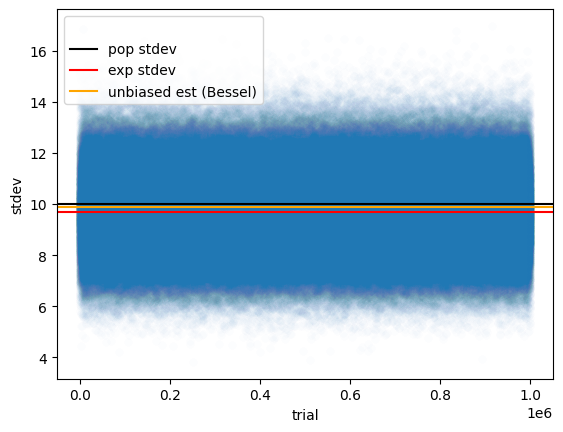

In [127]:
ax = sns.scatterplot(data=df2, x= df2['trial'], y = 'stdev', alpha = 0.01)
plt.axhline(pop_std, color= 'black')
plt.axhline(exp_avg_stdev, color = 'red')
plt.axhline(exp_avg_stdev * np.sqrt(sample_size/(sample_size-1)), color = 'orange')

labels = ["", "pop stdev", "exp stdev", "unbiased est (Bessel)"]
handles, _ = ax.get_legend_handles_labels()

# Slice list to remove first handle
plt.legend(labels = labels, loc= 'upper left')

#plt.legend()
plt.show()

It appears that the Bessel correction factor is under-estimating the standard deviation ever so slightly. In further study, we can examine if this remains true over many large samples...

**Currently, I think there is an error in the treatment/placement of square roots. I am trying to get to the bottom of this**

### Concluding Questions for Thought ###

* How does a change in sample size affect the Bessel correction factor? If we change the sample size, how will that change the rate of an 'error'?

* Why will the experiment with 100 samples sometimes give an answer that is counter to our assumptions and arguments? Could this happen with a 1,000,000 sample experiment? If so, how likely is that to happen?

* Does changing the population mean or standard deviation change our interpretation of the experiment? What does this mean for our understanding of the normal distribution and its general applications?

**From here on is a code graveyard that has sketches of ideas**

In [175]:
# Generate data -- 10,000(?) samples of random size between 10 and 100.
# Plot the stdev of each sample vs. the sample size

pop_mean = 100
pop_std = 10

arr = []

for _ in range(100000):
    n = np.random.randint(10, 101)
    sample_stdev = np.std(np.random.normal(pop_mean, pop_std, n))
    row = [n, sample_stdev, 10/sample_stdev]
    arr.append(row)
    
df3 = pd.DataFrame(data = arr, columns= ['sample size', 'stdev', 'stdev ratio'])

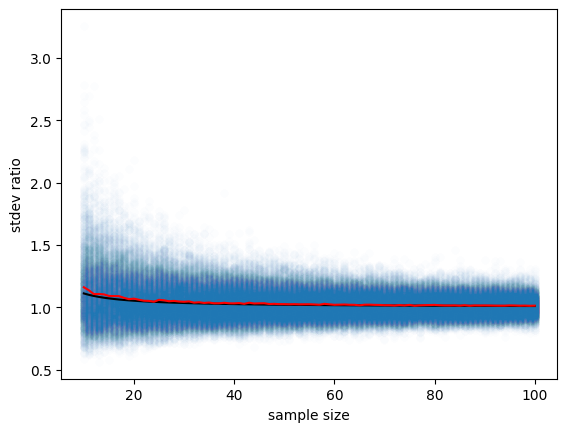

In [186]:
x = [i for i in range(10, 101)]
y = [i/(i-1) for i in x]
z = [np.mean(df3['stdev ratio'][df3['sample size'] == i]) for i in x]

sns.scatterplot(data=df3, x='sample size', y='stdev ratio', alpha = 0.01)
plt.plot(x,y, color = 'black')
plt.plot(x, z, color='red')

plt.show()

The above graph is very interesting-- we should continue to examine how the estimates become better at larger sample sizes.

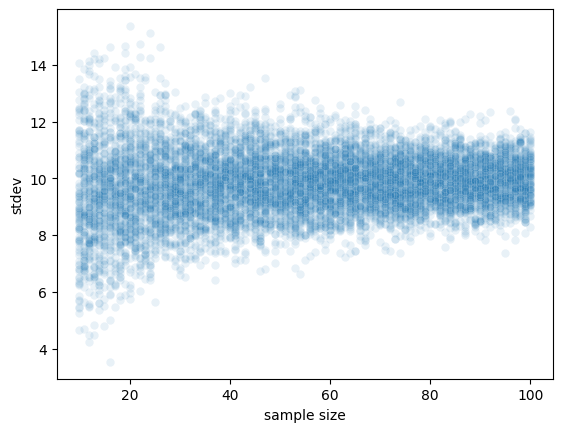

In [59]:
sns.scatterplot(data=df2, x = 'sample size', y = 'stdev', alpha = 0.1);

In [146]:
def experiment_var(pop_mean: float, pop_std: float, n: int, n_prime: int) -> pd.DataFrame:
    '''Returns a randomly generated Data Frame that contains the standard deviations of many individual samples, and averages 
    the results. This process is repeated many times and added to the data frame.
    
    param: pop_mean: the known population mean
    param: pop_std: the know population standard deviation
    param: n: the sample size of the lowest level sample
    param: n_prime: the number of trials take in the experiment
    
    return: a pandas dataframe that contains the generated experiment data'''
    
    # Put this on hold...we might not need something this complicated
    
    exp_array = []
    
    for i in range(1, n_prime+1):
        variance = np.var(np.random.normal(pop_mean, pop_std, n))
        stdev = np.std(np.random.normal(pop_mean, pop_std, n))
        row = [i, variance, stdev]
        exp_array.append(row)
        
    return pd.DataFrame(data = exp_array, columns=['trial', 'variance', 'stdev'])

In [147]:
df4 = experiment_var(pop_mean, pop_std, 25, 1_000_000)

In [156]:
np.sqrt(df4['variance'].mean()) * np.sqrt(25/24)

10.001168327195469

In [149]:
df4['variance'].mean()

96.0224331925419

In [154]:
print(np.mean([i * np.sqrt(25/24) for i in df4['stdev']]))

9.897307371157398


In [151]:
print(df4['stdev'].mean())
print(df4['stdev'].mean() * np.sqrt(25/24))

9.697341154728951
9.897307371157394


In [167]:
df4['check'] = np.sqrt(df4['variance'])
df4.head()

,trial,variance,stdev,check
0,1,111.894214,9.085210,10.578006
1,2,80.266103,10.120973,8.959135
2,3,122.951606,8.000875,11.088355
3,4,136.581175,11.225175,11.686795
4,5,97.348841,11.397441,9.866552


0